In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

sns.set_style('darkgrid')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = np.array((16, 9)) * .7

In [2]:
def bayes_lin_reg(x, y):
    with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
        # Define priors
        sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
        intercept = pm.Normal('b', 0, sigma=20)
        x_coeff = pm.Normal('a', 0, sigma=20)

        # Define likelihood
        likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                            sigma=sigma, observed=y)

        # Inference!
        trace = pm.sample(3000, cores=2) # draw 3000 posterior samples using NUTS sampling

        # Prediction
        post = pm.sample_posterior_predictive(trace, var_names=('a', 'b'))
        yhat = lambda t: post['a'] * t + post['b']

    return model, trace, yhat

def ARMA_week(ts):
    with pm.Model() as model:
        # Regression coefficients
        rho0 = pm.Normal('drift', sigma=10) # trend
        rho1 = pm.Normal('ar', sigma=10) # autoregression nn previous value
        rho7 = pm.Normal('day', sigma=10) # seasonality with lag 7 - length of week
        rho = [rho0, rho1, 0, 0, 0, 0, 0, rho7] # coefficients with lag 2 to 6 are 0
        
        # Noise amplitude, eps ~ N(0, sigma^2)
        sigma = pm.HalfCauchy("sigma", beta=10)
        
        # Define likelihood
        likelihood = pm.AR(rho, sigma=sigma)

        # Inference
        trace = pm.sample(3000, core=2)

        # Prediction
        post = pm.sample_posterior_predictive(trace, var_names=("drift", "ar", "day"))
        yhat = lambda t, y0: y0 if t==0 else post["drift"] + post["ar"] * yhat(t-1, y0) + post["day"] * yhat(max(t-7, 0), y0) # this is weird

    return model, trace, yhat

In [3]:
# Toy example
rho0 = 1
rho1 = .1
rho7 = .8
sigma = 2
t = np.linspace(0, 70, 70)
y0 = 1
y = [y0]
for tt in t[:-1]:
    y.append(rho0 + rho1*y[-1] + rho7*(y[-7] if len(y)>=7 else 0) + sigma*np.random.randn())
y = np.array(y)

In [4]:
#ARMA_week(y)

In [5]:
class Transit:

    cities = {
        'NY': 'New York City',
        'SF': 'San Francisco - Bay Area',
        'PH': 'Phoenix',
        'DA': 'Dallas',
    }

    # fpath = 'https://raw.githubusercontent.com/Metaculus/Mobility/master/MobilityData.csv'
    fpath = '/home/javi/projects/metaculus/mobility/applemobilitytrends-2020-12-22.csv'

    def __init__(self, city, fpath=None):
        
        self.city = city
        self._city = self.cities[self.city]
        
        if fpath is None:
            fpath = self.fpath
        else:
            self.fpath = fpath

        self._data = self._load()

    def linear_fit(self, t0=None, t1=None):
        t = self.ts.loc[t0:t1].index.values
        y = self.ts.loc[t0:t1].values

        self.model, self.trace, self.yhat = bayes_lin_reg(x=t, y=y)

    def predict(self, t):
        return pd.Series(self.yhat(t1))

    @property
    def ts(self):
        return self._data.groupby(lambda _: _.week).mean()

    def _load(self):
        df = pd.read_csv(self.fpath)
        ts = df[(df.region == self._city) & (df.transportation_type == 'transit')].squeeze().drop([
            'geo_type',
            'region',
            'transportation_type',
            'alternative_name',
            'sub-region',
            'country'
            ]).rename(self.city).astype(float)

        ts.index = ts.index.map(lambda _: pd.to_datetime(_, format="%Y-%m-%d"))

        return ts

In [6]:
cities = {k: Transit(k) for k in ('SF', 'NY', 'PH', 'DA')}

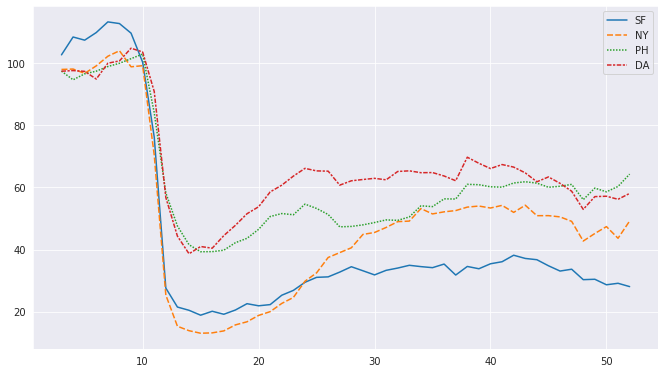

In [7]:
sns.lineplot(data=pd.concat([cities[k].ts for k in cities.keys()], axis=1))

In [8]:
t0 = 40
t1 = pd.to_datetime("2021/12/31").week + pd.to_datetime("2021/1/26").week
for k, v in cities.items():
    v.linear_fit(t0=t0)
    mn, p25, p50, p75, mx = map(lambda p: v.predict(t=t1).describe().loc[p], ('min', '25%', '50%', '75%', 'max'))
    print(f'\n{k} quartiles:\n[{mn:.2f}, {p25:.2f}]\n[{p25:.2f}, {p50:.2f}]\n[{p50:.2f}, {p75:.2f}]\n[{p75:.2f}, {mx:.2f}]\n')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 13 seconds.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



SF quartiles:
[21.36, 25.04]
[25.04, 25.97]
[25.97, 27.04]
[27.04, 35.08]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 12 seconds.
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6588208939861946, but should be close to 0.8. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.



NY quartiles:
[36.78, 43.83]
[43.83, 45.62]
[45.62, 47.90]
[47.90, 60.84]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 18 seconds.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.



PH quartiles:
[56.50, 60.96]
[60.96, 62.13]
[62.13, 63.42]
[63.42, 70.56]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 14 seconds.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.716455811972165, but should be close to 0.8. Try to increase the number of tuning steps.
There were 695 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47483081547322703, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


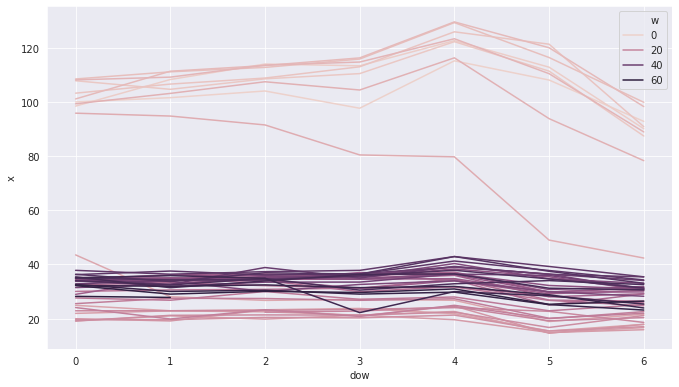

In [9]:
sns.lineplot(data=(lambda s: pd.DataFrame(np.array([s.values, s.index.week.values, s.index.dayofweek.values]).T, columns=['x', 'w', 'dow']))(cities['SF']._data), x='dow', y='x', hue='w')

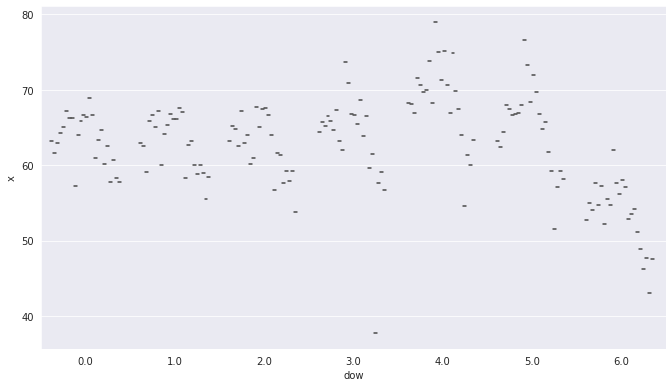

In [10]:
ax = sns.violinplot(data=(lambda df: df[df.w >= 29])((lambda s: pd.DataFrame(np.array([s.values, s.index.week.values, s.index.dayofweek.values]).T, columns=['x', 'w', 'dow']))(cities['DA']._data)), x='dow', y='x', hue='w')
ax.get_legend().remove()

In [11]:
cities['NY']._data

2020-01-13    100.00
2020-01-14     92.66
2020-01-15     95.29
2020-01-16     96.42
2020-01-17    107.50
               ...  
2020-12-18     50.48
2020-12-19     51.58
2020-12-20     41.36
2020-12-21     49.23
2020-12-22     49.14
Name: NY, Length: 345, dtype: float64